Import various packages needed to run the code

In [1]:
import qiskit
import numpy as np
from scipy.stats import chisquare
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from qiskit import IBMQ
from qiskit import Aer,execute
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

In [3]:
from collections import Counter
import random

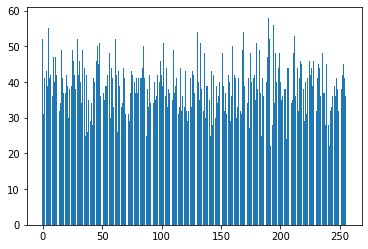

In [4]:
n = 10000
c = Counter(random.randint(0,255) for i in range (n))

plt.bar(c.keys(), c.values())
plt.show()



**Quantum Circuit**
Activate the IBM quantum experience account, create a register with 1 qubit and 1 classical bit, apply a Hadamard gate to the qubit, and measure the result onto the classical bit

In [5]:
IBMQ.enable_account("2a8edc73be45e6e6b70e8868bfd8014e89337f4007ca10b37425e7e5b128e64e631f2e56e55f3da11351080fd9babc3d4c70380fca976396cdade1ef875160fe")

/Users/student/Library/Python/3.8/lib/python/site-packages/qiskit/providers/ibmq/ibmqfactory.py:109: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

Look at qubit error and error correction

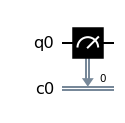

In [6]:
# Set up quantum circuit with one qubit

qr = qiskit.QuantumRegister(1)
cr = qiskit.ClassicalRegister(1)
circuit = qiskit.QuantumCircuit(qr,cr)

circuit.measure(qr,cr)
circuit.draw(output = "mpl", scale = 1)

In [7]:
simulator = Aer.get_backend("qasm_simulator")
simulator_result = execute(circuit, backend = simulator, shots = 1024).result()

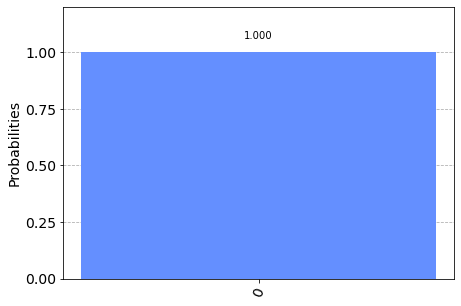

In [8]:
plot_histogram(simulator_result.get_counts(circuit))

In [11]:
provider = IBMQ.get_provider(hub = "ibm-q")
qbackend = provider.get_backend("ibmq_armonk")
job_experiment = execute(circuit, backend = qbackend, shots = 1024)
job_monitor(job_experiment)

Job Status: job has successfully run


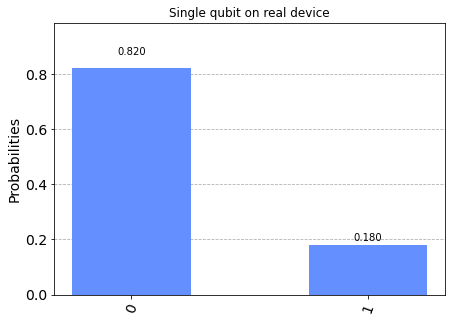

In [14]:
device_result = job_experiment.result()
plot_histogram(device_result.get_counts(circuit), title = "Single qubit on real device")

In [16]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel = "mcal")

In [17]:
for q_circuit in meas_calibs:
    print(q_circuit)

       ░ ┌─┐
q0_0: ─░─┤M├
       ░ └╥┘
c1: 1/════╩═
          0 
      ┌───┐ ░ ┌─┐
q0_0: ┤ X ├─░─┤M├
      └───┘ ░ └╥┘
c1: 1/═════════╩═
               0 


In [18]:
cal_job = execute(meas_calibs, backend = qbackend, shots = 1024, optimization_level = 0)
job_monitor(cal_job)
cal_results = cal_job.result()

Job Status: job has successfully run


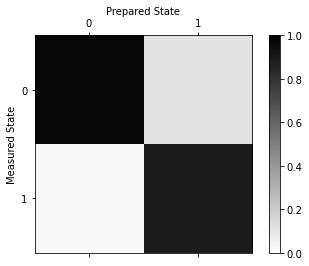

In [19]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel = "mcal")
fig,ax = plt.subplots()
meas_fitter.plot_calibration(ax=ax)

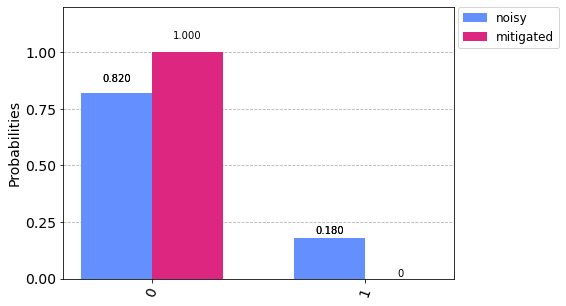

In [20]:
meas_filter = meas_fitter.filter
mitigated_results = meas_filter.apply(cal_results)
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_results.get_counts(0)
plot_histogram([device_counts, mitigated_counts], legend = ["noisy", "mitigated"])

**Error correction on 5 qubits**

First create a circuit with 5 qubits and 5 classical bits

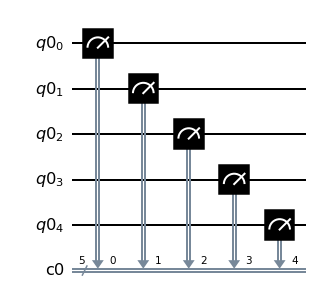

In [6]:
num_qubits = 5
qr = qiskit.QuantumRegister(num_qubits)
cr = qiskit.ClassicalRegister(num_qubits)

circuit = qiskit.QuantumCircuit(qr,cr)

circuit.measure(qr,cr)
circuit.draw(output = "mpl", scale = 1)

In [20]:
simulator = Aer.get_backend("qasm_simulator")
simulator_result = execute(circuit, backend = simulator, shots = 1024).result()

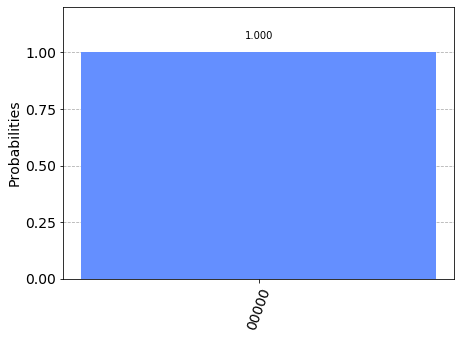

In [21]:
plot_histogram(simulator_result.get_counts(circuit))

In [22]:
# from qiskit.providers.ibmq import least_busy
# provider = IBMQ.get_provider(hub = "ibm-q")
# devices = provider.backends(filters = lambda x: x.configuration().n_qubits == 5
#                                      and not x.configuration().simulator)
provider = IBMQ.get_provider(hub = "ibm-q")
qbackend = provider.get_backend("ibmq_ourense")
print(qbackend)

ibmq_ourense


In [23]:
job_experiment = execute(circuit, backend = qbackend, shots = 8192, optimization_level = 0)
job_monitor(job_experiment)

Job Status: job has successfully run


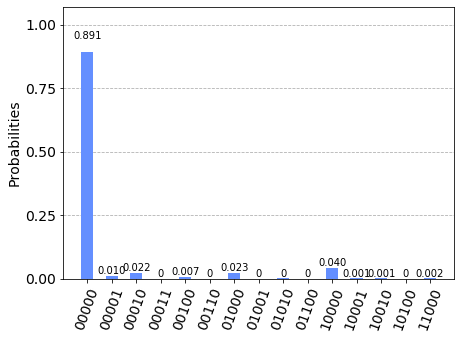

In [24]:
device_result = job_experiment.result()
plot_histogram(device_result.get_counts(circuit))

In [25]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel = "mcal")

In [26]:
cal_job = execute(meas_calibs, backend = qbackend, shots = 8192, optimization_level = 0)
job_monitor(cal_job)
cal_results = cal_job.result()

Job Status: job has successfully run


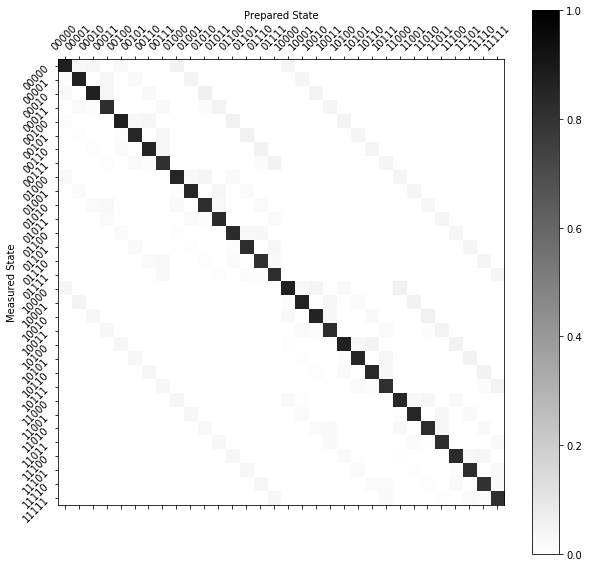

In [27]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel = "mcal")
fig,ax = plt.subplots(figsize = (10,10))
ax.tick_params(labelrotation = 45)
meas_fitter.plot_calibration(ax=ax)

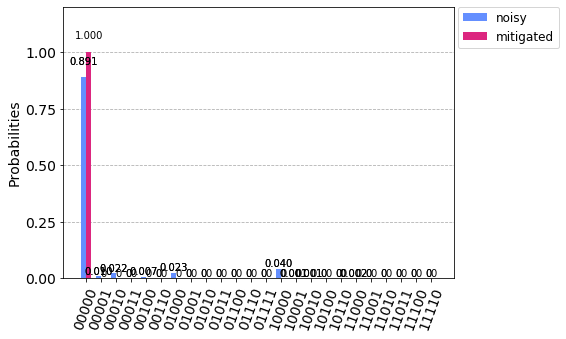

In [28]:
meas_filter = meas_fitter.filter
mitigated_results = meas_filter.apply(cal_results)
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_results.get_counts(0)
plot_histogram([device_counts, mitigated_counts], legend = ["noisy", "mitigated"])

Steps for experiment:

* Create 5 qubit circuit and apply Hadamard gate to each qubit
* Create function to run circuit 20 times in order to get 100,000 8 bit numbers
* Convert 8 bit numbers into integers
* Calculate the Chi-squared value

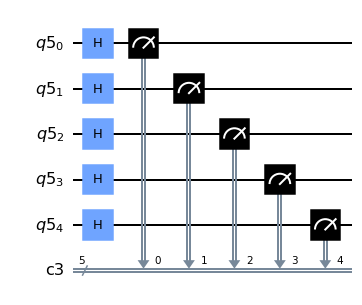

In [29]:
num_qubits = 5
qr = qiskit.QuantumRegister(num_qubits)
cr = qiskit.ClassicalRegister(num_qubits)

circuit_rng = qiskit.QuantumCircuit(qr,cr)
circuit_rng.h(qr)

circuit_rng.measure(qr,cr)
circuit_rng.draw(output = "mpl", scale = 1)

In [30]:
qrng_all = ""

In [31]:
for i in range(200):
    print("run " + str(i))
    qrng_execute = execute(circuit_rng, backend = qbackend, shots = 8192, memory = True, optimization_level = 0)
    job_monitor(qrng_execute)
    circuit_results = qrng_execute.result()
    mitigated_qrng_results = meas_filter.apply(circuit_results)
    circuit_results_binary = ''.join(map(str, mitigated_qrng_results.get_memory()))
    qrng_all = qrng_all + circuit_results_binary

run 0
Job Status: job has successfully run
run 1
Job Status: job has successfully run
run 2
Job Status: job has successfully run
run 3
Job Status: job has successfully run
run 4
Job Status: job has successfully run
run 5
Job Status: job has successfully run
run 6
Job Status: job has successfully run
run 7
Job Status: job has successfully run
run 8
Job Status: job has successfully run
run 9
Job Status: job has successfully run
run 10
Job Status: job has successfully run
run 11
Job Status: job has successfully run
run 12
Job Status: job has successfully run
run 13
Job Status: job has successfully run
run 14
Job Status: job has successfully run
run 15
Job Status: job has successfully run
run 16
Job Status: job has successfully run
run 17
Job Status: job has successfully run
run 18
Job Status: job has successfully run
run 19
Job Status: job has successfully run
run 20
Job Status: job has successfully run
run 21
Job Status: job has successfully run
run 22
Job Status: job has successfully ru

In [32]:
len(qrng_all)

8192000

In [33]:
qrng_int = []
for i in range(int(len(qrng_all))):
    if i % 8 == 0:
        qrng_int.append(int(qrng_all[i:i+8], 2))
        
print(len(qrng_int))
print(qrng_int[125])

1024000
76


<BarContainer object of 256 artists>

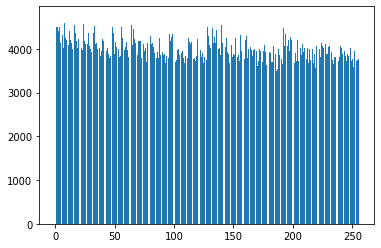

In [34]:
qrng_count = Counter(qrng_int)
plt.bar(qrng_count.keys(), qrng_count.values())

In [39]:
type(qrng_all)

str

In [35]:
type(qrng_int)

list

In [41]:
import pandas as pd   

df = pd.DataFrame(qrng_int)  
    
df.to_csv('QRNG.csv', index = False)

In [42]:
df = pd.DataFrame(list(qrng_all))

df.to_csv('QRNG_binary.csv', index = False)